# COMP4211  Software Project 

<p style="text-align: left;">
Name: Fong Man Hin <br \>
SID: 20624888 <br \>
</p>

## Outline
1. Define Task
2. Data Preprocessing
3. Build LSTM model
4. Model training & prediction
6. Testing & Result

## 1. Define Task

### Target Task
We will forecast electricity load demand for Jan-2020 based on Training dataset from 2015-2019 using different LSTM model and compare their accuracy.

## 2. Data Preprocessing

In [176]:
import os, pprint, time, matplotlib, torch
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import os.path as osp
import torch.optim as optim
from torch.utils.data import DataLoader
from matplotlib.pyplot import figure
from sklearn.preprocessing import MinMaxScaler
from torchsummaryX import summary
from tqdm import tqdm

In [151]:
def remove_stock_split_days(dfs_dict):
    tgt_list = list(dfs_dict.keys())
    masked_index = dfs_dict[tgt_list[0]].index
    for i in range(1, len(tgt_list)):
        masked_index = masked_index.intersection(dfs_dict[tgt_list[i]].index)
    for i in range(len(tgt_list)):
        dfs_dict[tgt_list[i]] = dfs_dict[tgt_list[i]].loc[masked_index]
    return masked_index

def get_preprocessed_data_close_price(tgt_period, tgt_intv, company_index_list, company_name_list):
    ## compute target companies close price
    ticker_list = yf.Tickers(company_index_list)
    close_dict = {}
    for idx, name in zip(company_index_list, company_name_list):
        close_dict[name] = ticker_list.tickers[idx].history(period=tgt_period, interval=tgt_intv)['Close']

    masked_index = remove_stock_split_days(close_dict)
    print("\nAfter filtering out rows")
    for idx, name in zip(company_index_list, company_name_list):
        print(idx, name, close_dict[name].shape)
    close_final = pd.DataFrame(close_dict)
    print("[Final X] ", close_final.shape)

    mask_bool = np.invert(close_final.isnull().values.any(axis=1))
    close_final = close_final[mask_bool]

    ## compute QQQ close price
    qqq_price = 'QQQ'
    qqq_df = yf.Tickers(qqq_price).tickers[qqq_price].history(period=tgt_period, interval=tgt_intv)
    qqq_df = qqq_df.drop([c for c in qqq_df.columns if c != 'Close'], axis=1)
    qqq_df = qqq_df.loc[close_final.index]  ## remove the QQQ rows which are not in company info
    return close_final, qqq_df

def plot_close_price(close_final, qqq_df):
    plt.figure(figsize=(15,12))
    for c in close_final.columns:
        plt.plot(close_final[c], label=c)
    plt.plot(qqq_df, label='QQQ')
    plt.title('Trend of Close Price')
    #plt.xticks(rotation=100)
    plt.legend()
    plt.show()

In [152]:
tgt_period, tgt_intv = '2y', '1d'
stocks = ["AAPL","ADBE","AMZN","AVGO","FB","GOOG","GOOGL","MSFT","NVDA","TSLA"]
stocks_name = ['Apple', 'Adobe', 'Amazon', 'Broadcom', 'Facebook', 'Google-C', 'Google-A', 'Microsoft', 'Nvida', 'Tesla']
close_df, qqq_df = get_preprocessed_data_close_price(tgt_period, tgt_intv, stocks, stocks_name)



After filtering out rows
AAPL Apple (507,)
ADBE Adobe (507,)
AMZN Amazon (507,)
AVGO Broadcom (507,)
FB Facebook (507,)
GOOG Google-C (507,)
GOOGL Google-A (507,)
MSFT Microsoft (507,)
NVDA Nvida (507,)
TSLA Tesla (507,)
[Final X]  (507, 10)


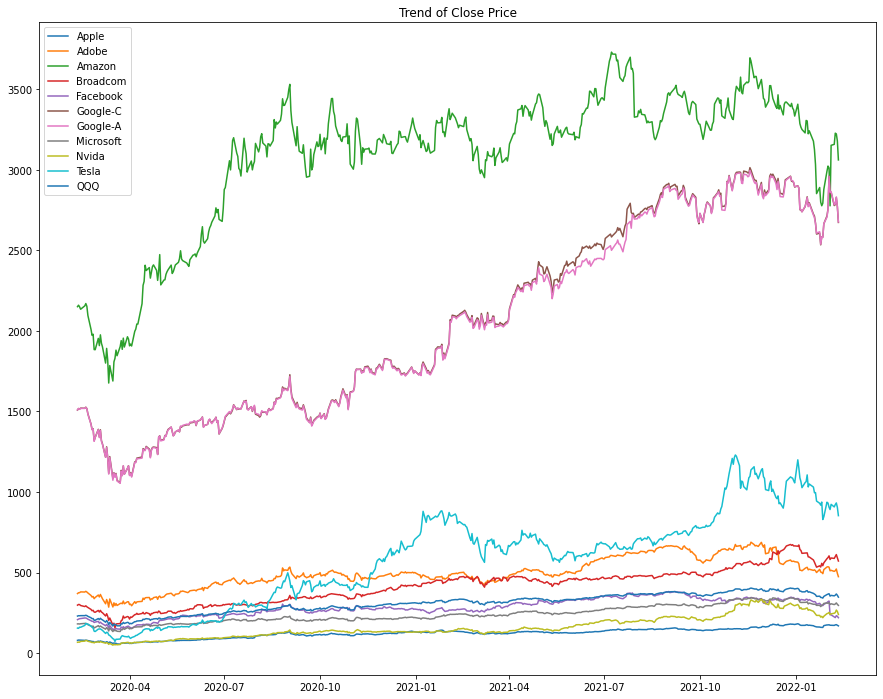

In [153]:
plot_close_price(close_df, qqq_df)

In [154]:
close_df

,Apple,Adobe,Amazon,Broadcom,Facebook,Google-C,Google-A,Microsoft,Nvida,Tesla
Date,,,,,,,,,,
2020-02-11,78.819427,369.279999,2150.800049,297.345184,207.190002,1508.790039,1510.060059,180.989487,66.803833,154.876007
2020-02-12,80.691208,374.290009,2160.000000,301.561646,210.759995,1518.270020,1518.630005,181.254456,67.963402,153.457993
2020-02-13,80.116608,374.839996,2149.870117,300.883698,213.139999,1514.660034,1513.390015,180.273148,67.524506,160.800003
2020-02-14,80.136330,379.670013,2134.870117,295.125549,214.179993,1520.739990,1518.729980,181.882477,72.265045,160.005997
2020-02-18,78.669006,378.850006,2155.669922,288.605743,217.800003,1519.670044,1519.439941,183.727295,73.955780,171.679993
...,...,...,...,...,...,...,...,...,...,...
2022-02-07,171.660004,507.100006,3158.709961,587.630005,224.910004,2778.760010,2784.020020,300.950012,247.279999,907.340027
2022-02-08,174.830002,511.309998,3228.270020,600.219971,220.179993,2784.260010,2787.979980,304.559998,251.080002,922.000000
2022-02-09,176.279999,521.750000,3223.790039,611.340027,232.000000,2829.060059,2831.840088,311.209991,267.049988,932.000000


In [155]:
class PriceDataset(data.Dataset):
    def __init__(self, Xs, Ys, window_size):
        self.Xs = Xs
        self.Ys = Ys
        self.window_size = window_size

    def __getitem__(self, idx):
        xs = self.Xs[idx:idx + self.window_size]
        y = self.Ys[idx + self.window_size]
        return torch.tensor(xs, dtype=torch.float), torch.tensor(y, dtype=torch.float)

    def __len__(self):
        return len(self.Ys) - self.window_size

    def scaling(self, mean, std):
        self.Ys = (self.Ys - mean) / std
        self.mean = mean
        self.std = std


In [159]:
window_size = 5
train_split_ratio = 0.8

## split train and val set
Xs, Ys = close_df.values, qqq_df.values
num_train_row = int(len(Xs) * train_split_ratio)
Xs_train, Ys_train = Xs[:num_train_row], Ys[:num_train_row]
Xs_val, Ys_val = Xs[num_train_row:], Ys[num_train_row:]
print(Ys_train.shape, Ys_val.shape)

train_set = PriceDataset(Xs_train, Ys_train, window_size)
val_set = PriceDataset(Xs_val, Ys_val, window_size)
train_mean = train_set.Ys.mean()
train_std = train_set.Ys.std()
train_set.scaling(train_mean, train_std)
val_set.scaling(train_mean, train_std)
print("[Size] Train_Set: {} | Val_Set: {}".format(len(train_set), len(val_set)))


(405, 1) (102, 1)
[Size] Train_Set: 400 | Val_Set: 97


## 3. Build LSTM model

In [179]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(LSTMNet, self).__init__()
        self.norm1 = nn.BatchNorm1d(input_size) # [n_batch, input_size]
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True, 
        )
        self.regressor = nn.Linear(hidden_size, 1)

    def forward(self, Xs): # Xs : [n_batch, window_size, input_size]
        Xs = self.norm1(Xs.flatten(0, 1)).reshape(Xs.shape) #  batchnorm1d([n_batch * window_size, input_size]) => reshape into [n_batch, window_size, input_size]
        rnn_out, _ = self.lstm(Xs) # rnn_out: [n_batch, window_size, hidden_size]
        ## torch.sum(rnn_out, dim=1) # [n_batch, hidden_size]
        out = self.regressor(rnn_out[:, -1]) # batch first
        return out

In [181]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_size, hidden_size, num_layers, dropout = 10, 64, 2, 0.2
lstm_net = LSTMNet(input_size, hidden_size, num_layers, dropout)
lstm_net.to(device)
summary(lstm_net, torch.rand(4, 10, 10).to(device))


            Kernel Shape Output Shape  Params  Mult-Adds
Layer                                                   
0_norm1             [10]     [40, 10]      20         10
1_lstm                 -  [4, 10, 64]   52736      51712
2_regressor      [64, 1]       [4, 1]      65         64
--------------------------------------------------------
                      Totals
Total params           52821
Trainable params       52821
Non-trainable params       0
Mult-Adds              51786


/opt/anaconda3/lib/python3.9/site-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_norm1,[10],"[40, 10]",20,10
1_lstm,-,"[4, 10, 64]",52736,51712
2_regressor,"[64, 1]","[4, 1]",65,64


In [182]:
def train_epoch(net, optimizer, loss_fn, dataloader, epoch, writer=None, device='cpu'):
    ep_loss = 0.0
    num_iter = len(dataloader)
    net.train()
    grad_max = 100.
    for n_iter, (xs, y) in enumerate(tqdm(dataloader)):
        curr_iter = epoch * num_iter + n_iter
        xs, y = xs.to(device), y.to(device)
        pred = net(xs) ## step 1. get output
        loss = loss_fn(pred, y) ## step 2. compute loss
        optimizer.zero_grad()
        loss.backward() ## step 3. backpropagation
        nn.utils.clip_grad_norm_(net.parameters(), grad_max) ## L2-norm gradient clipping
        optimizer.step() ## step 4. update model weigth
        if writer is not None:
            writer.add_scalar('Loss/train', loss.data, curr_iter)
        # print("\n[ITER %d] LOSS: %.4f" % (curr_iter, loss.data))
        ep_loss += loss.data
    ep_loss /= len(dataloader)
    if writer is not None:
        writer.add_scalar('EpLoss/train', ep_loss, epoch)
    print("\n[EP %d] Train LOSS: %.4f" % (epoch, ep_loss))
    return ep_loss

@torch.no_grad()
def val_epoch(net, loss_fn, dataloader, epoch, val_set, writer=None, device='cpu'):
    ep_loss = 0.0
    net.eval()
    preds, ys = [], []
    for n_iter, (xs, y) in enumerate(tqdm(dataloader)):
        xs, y = xs.to(device), y.to(device)
        pred = net(xs)
        loss = loss_fn(pred, y)
        ep_loss += loss.data
        preds.append(pred.squeeze())
        ys.append(y)
    ep_loss /= len(dataloader)
    print("\n[EP %d] Val LOSS: %.4f" % (epoch, ep_loss))

    preds = torch.stack(preds).squeeze()
    ys = torch.stack(ys).squeeze()
    # if (epoch + 1) % 5 == 0:
    ## denormalize
    preds = preds * val_set.std + val_set.mean
    ys = ys * val_set.std + val_set.mean

    ## plot the prediction and GT close value
    plt.plot(ys.cpu().numpy(), label='GT')
    plt.plot(preds.cpu().numpy(), label='pred')
    plt.title("[Ep %d] GT vs Pred"%(epoch))
    plt.legend()
    plt.show()

    if writer is not None:
        writer.add_scalar('EpLoss/val', ep_loss, epoch)
    return ep_loss

def train_main(net, train_set, val_set, loss_fn, batch_size, lr, n_epoch):
    train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = data.DataLoader(val_set, batch_size=1)

    writer = None
    save_dir = './'
    # writer = SummaryWriter(log_dir=osp.join(save_dir, 'log'))
    device = 'cpu' if not torch.cuda.is_available() else 'cuda'
    net = net.to(device)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)

    train_ep_losses, val_ep_losses = [], []
    for epoch in range(n_epoch):
        train_loss = train_epoch(net, optimizer, loss_fn, train_loader, epoch, writer, device)
        val_loss = val_epoch(net, loss_fn, val_loader, epoch, val_set, writer, device)
        train_ep_losses.append(train_loss)
        val_ep_losses.append(val_loss)
        if (epoch + 1) % 5 == 0:
            os.makedirs(osp.join(save_dir, 'weights'), exist_ok=True)
            torch.save(net.state_dict(), osp.join(save_dir, 'weights/ep%d.pth' % (epoch + 1)))
    
    plt.plot(torch.tensor(train_ep_losses).cpu().numpy(), label='train')
    plt.plot(torch.tensor(val_ep_losses).cpu().numpy(), label='val')
    plt.xlabel('n_epoch')
    plt.legend()
    plt.show()

## 4. Model Training & prediction

/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 232.99it/s]



[EP 0] Train LOSS: 0.6228


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3239.36it/s]


[EP 0] Val LOSS: 0.8375


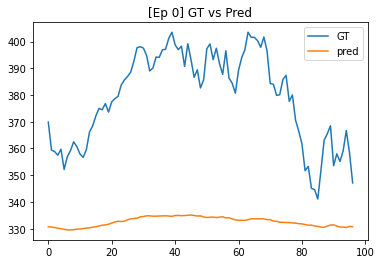

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 275.52it/s]



[EP 1] Train LOSS: 0.1652


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3196.25it/s]



[EP 1] Val LOSS: 0.1389


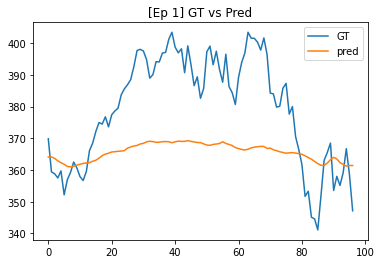

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 297.50it/s]



[EP 2] Train LOSS: 0.0541


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3218.83it/s]



[EP 2] Val LOSS: 0.0688


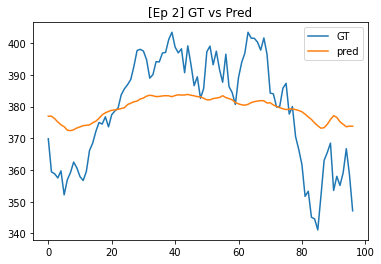

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 280.74it/s]



[EP 3] Train LOSS: 0.0764


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3100.43it/s]



[EP 3] Val LOSS: 0.1305


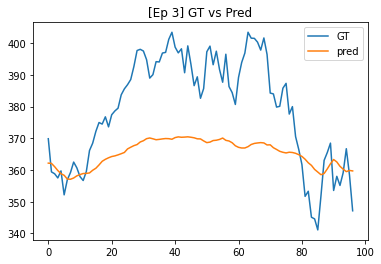

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 282.35it/s]



[EP 4] Train LOSS: 0.0638


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3245.56it/s]



[EP 4] Val LOSS: 0.0851


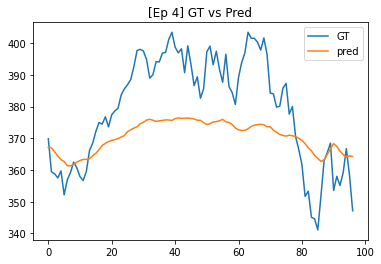

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 302.04it/s]



[EP 5] Train LOSS: 0.0466


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3295.41it/s]



[EP 5] Val LOSS: 0.0717


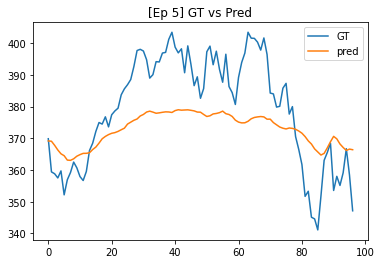

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 300.97it/s]



[EP 6] Train LOSS: 0.0351


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3361.85it/s]



[EP 6] Val LOSS: 0.0644


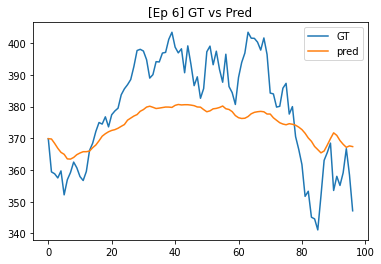

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 321.88it/s]



[EP 7] Train LOSS: 0.0637


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3762.47it/s]



[EP 7] Val LOSS: 0.0753


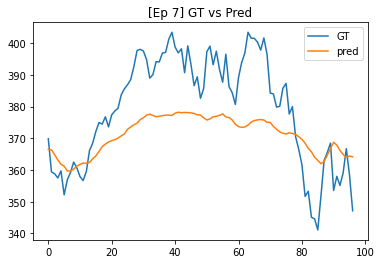

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 305.39it/s]



[EP 8] Train LOSS: 0.0434


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3351.99it/s]



[EP 8] Val LOSS: 0.0521


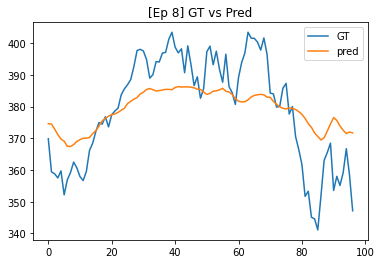

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 291.83it/s]



[EP 9] Train LOSS: 0.0490


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3548.05it/s]



[EP 9] Val LOSS: 0.0569


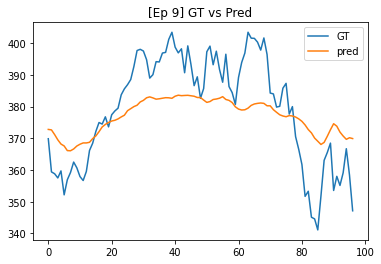

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 295.78it/s]



[EP 10] Train LOSS: 0.0490


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3380.17it/s]



[EP 10] Val LOSS: 0.0575


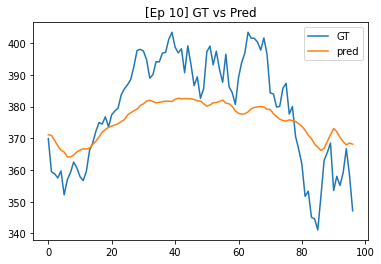

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 312.18it/s]



[EP 11] Train LOSS: 0.0563


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3588.73it/s]



[EP 11] Val LOSS: 0.0565


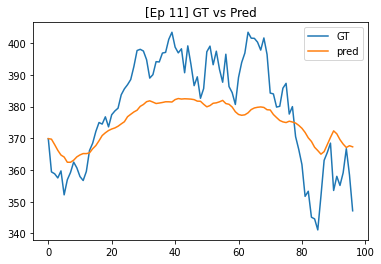

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 309.17it/s]



[EP 12] Train LOSS: 0.0356


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3569.18it/s]



[EP 12] Val LOSS: 0.0517


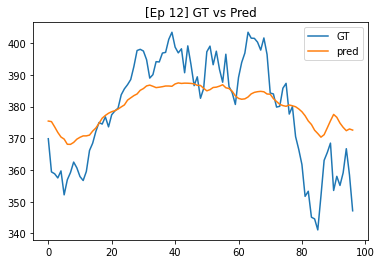

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 297.35it/s]



[EP 13] Train LOSS: 0.0452


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3422.57it/s]



[EP 13] Val LOSS: 0.0631


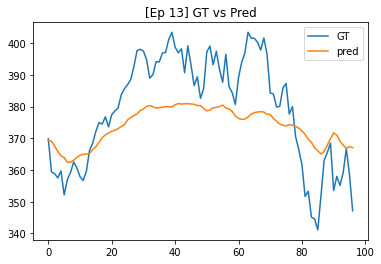

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 312.85it/s]



[EP 14] Train LOSS: 0.0554


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3742.71it/s]



[EP 14] Val LOSS: 0.0542


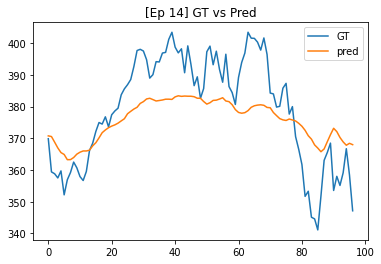

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 296.07it/s]



[EP 15] Train LOSS: 0.0349


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3302.23it/s]



[EP 15] Val LOSS: 0.0520


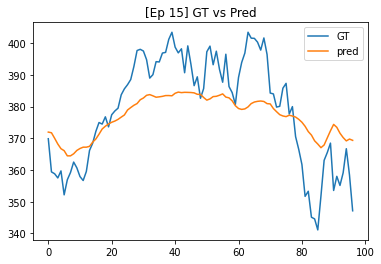

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 308.66it/s]



[EP 16] Train LOSS: 0.0392


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3532.55it/s]



[EP 16] Val LOSS: 0.0518


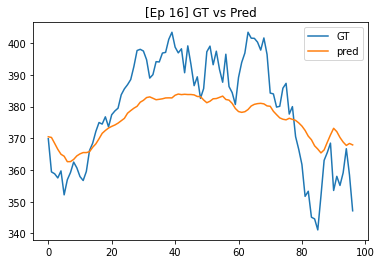

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 303.57it/s]



[EP 17] Train LOSS: 0.0422


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3573.54it/s]



[EP 17] Val LOSS: 0.0508


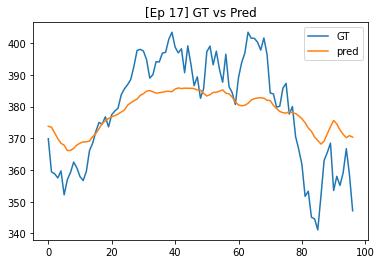

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 317.16it/s]



[EP 18] Train LOSS: 0.0439


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3414.18it/s]



[EP 18] Val LOSS: 0.0669


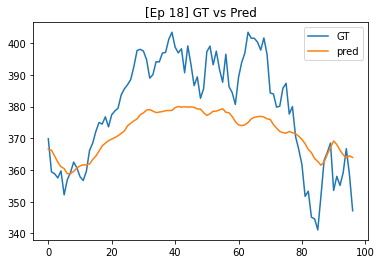

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 306.11it/s]



[EP 19] Train LOSS: 0.0441


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3510.67it/s]



[EP 19] Val LOSS: 0.0521


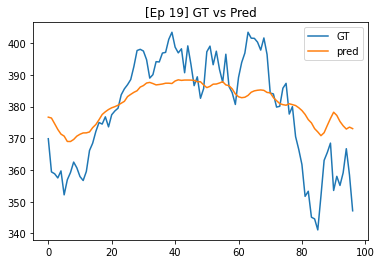

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 313.75it/s]



[EP 20] Train LOSS: 0.0352


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3561.18it/s]



[EP 20] Val LOSS: 0.0618


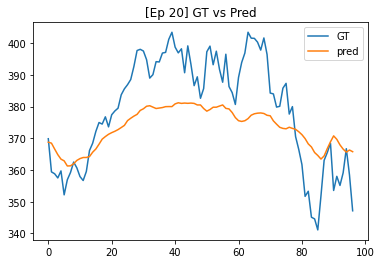

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 314.15it/s]



[EP 21] Train LOSS: 0.0565


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3724.89it/s]



[EP 21] Val LOSS: 0.0563


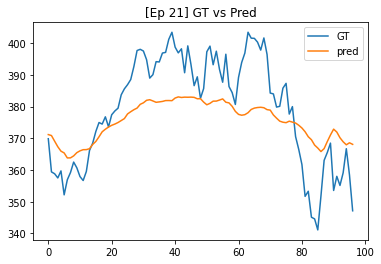

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 316.73it/s]



[EP 22] Train LOSS: 0.0477


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3815.01it/s]



[EP 22] Val LOSS: 0.0519


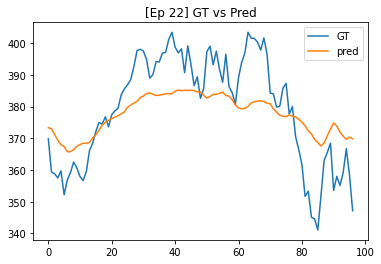

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 312.75it/s]



[EP 23] Train LOSS: 0.0380


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3532.24it/s]



[EP 23] Val LOSS: 0.0522


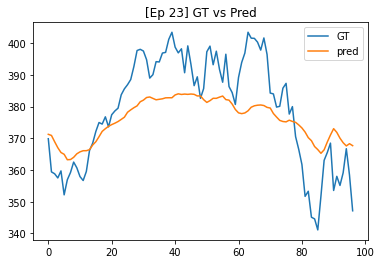

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 308.92it/s]



[EP 24] Train LOSS: 0.0355


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3570.65it/s]



[EP 24] Val LOSS: 0.0502


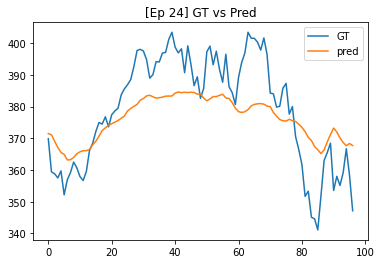

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 317.93it/s]



[EP 25] Train LOSS: 0.0455


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3482.09it/s]



[EP 25] Val LOSS: 0.0466


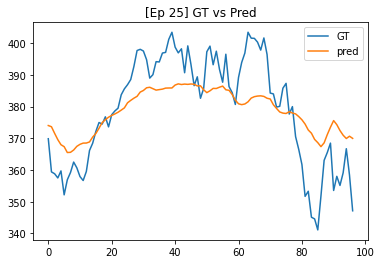

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 311.94it/s]



[EP 26] Train LOSS: 0.0465


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3643.76it/s]



[EP 26] Val LOSS: 0.0477


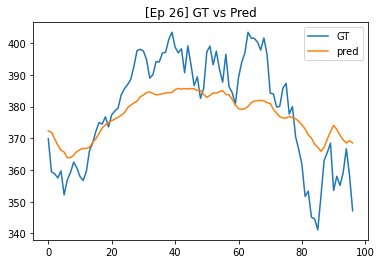

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 322.40it/s]



[EP 27] Train LOSS: 0.0369


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3541.19it/s]



[EP 27] Val LOSS: 0.0481


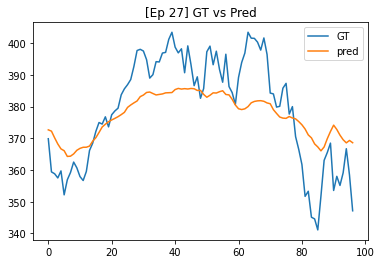

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 310.72it/s]



[EP 28] Train LOSS: 0.0377


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3442.14it/s]



[EP 28] Val LOSS: 0.0508


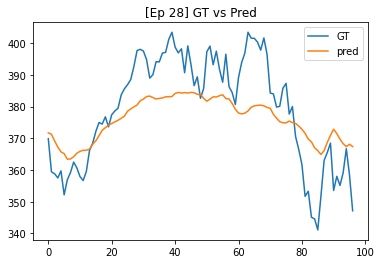

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 317.84it/s]



[EP 29] Train LOSS: 0.0295


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3707.55it/s]



[EP 29] Val LOSS: 0.0507


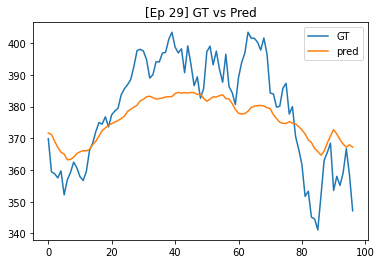

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 307.56it/s]



[EP 30] Train LOSS: 0.0386


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3625.09it/s]



[EP 30] Val LOSS: 0.0480


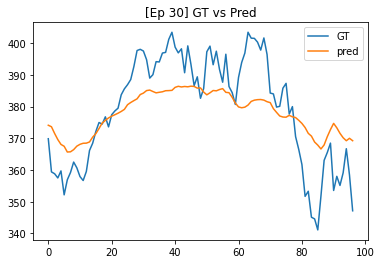

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 313.21it/s]



[EP 31] Train LOSS: 0.0463


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3643.17it/s]



[EP 31] Val LOSS: 0.0560


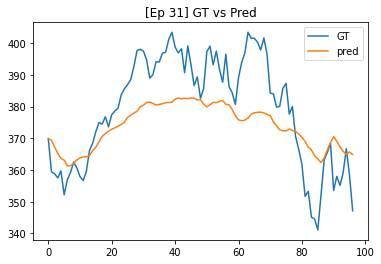

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 324.81it/s]



[EP 32] Train LOSS: 0.0339


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3728.92it/s]



[EP 32] Val LOSS: 0.0471


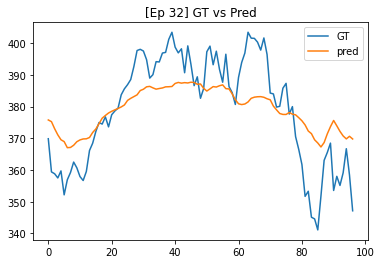

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 304.55it/s]



[EP 33] Train LOSS: 0.0298


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3482.93it/s]



[EP 33] Val LOSS: 0.0575


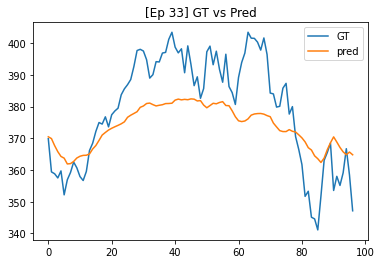

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 310.28it/s]



[EP 34] Train LOSS: 0.0222


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3557.73it/s]



[EP 34] Val LOSS: 0.0470


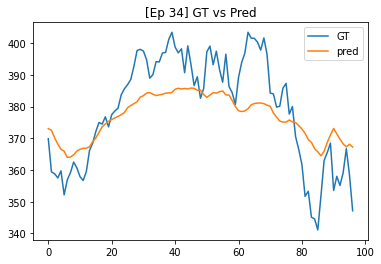

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 314.61it/s]



[EP 35] Train LOSS: 0.0282


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3644.84it/s]



[EP 35] Val LOSS: 0.0456


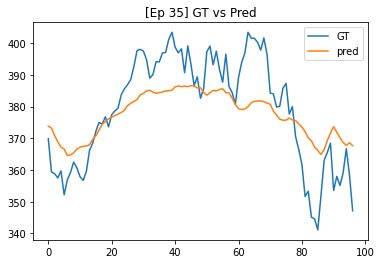

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 321.96it/s]



[EP 36] Train LOSS: 0.0472


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3627.81it/s]



[EP 36] Val LOSS: 0.0587


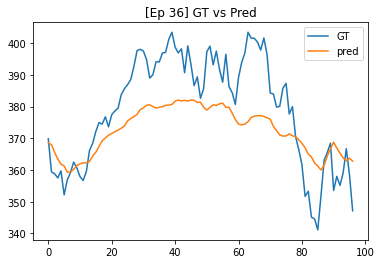

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 304.72it/s]



[EP 37] Train LOSS: 0.0419


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3443.86it/s]



[EP 37] Val LOSS: 0.0465


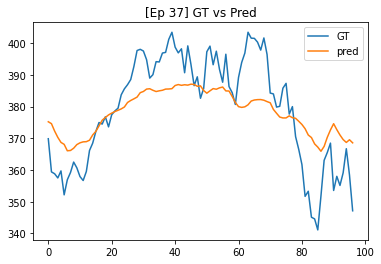

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 307.47it/s]



[EP 38] Train LOSS: 0.0393


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3642.39it/s]



[EP 38] Val LOSS: 0.0607


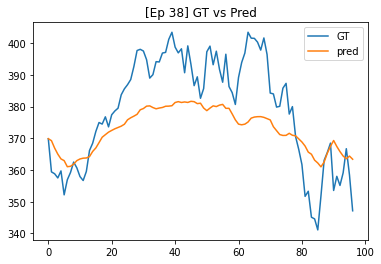

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 259.86it/s]



[EP 39] Train LOSS: 0.0346


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3183.87it/s]



[EP 39] Val LOSS: 0.0510


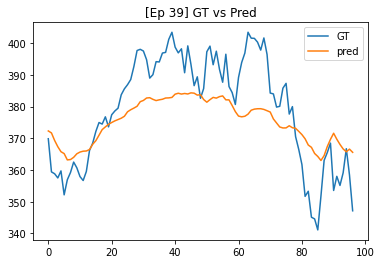

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 295.43it/s]



[EP 40] Train LOSS: 0.0389


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3600.55it/s]



[EP 40] Val LOSS: 0.0485


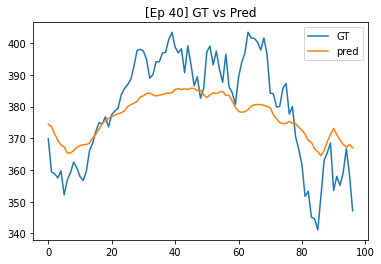

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 291.29it/s]



[EP 41] Train LOSS: 0.0322


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3311.50it/s]



[EP 41] Val LOSS: 0.0634


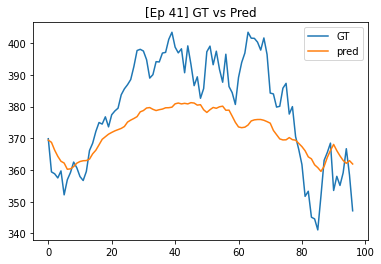

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 290.52it/s]



[EP 42] Train LOSS: 0.0616


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3302.49it/s]



[EP 42] Val LOSS: 0.0485


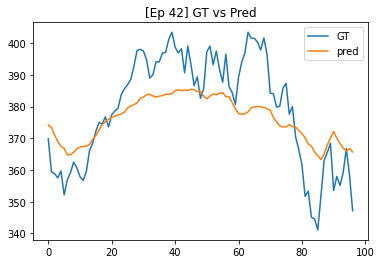

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 310.24it/s]



[EP 43] Train LOSS: 0.0346


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3227.00it/s]



[EP 43] Val LOSS: 0.0562


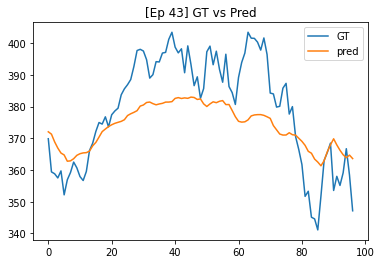

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 315.10it/s]



[EP 44] Train LOSS: 0.0287


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3532.40it/s]



[EP 44] Val LOSS: 0.0533


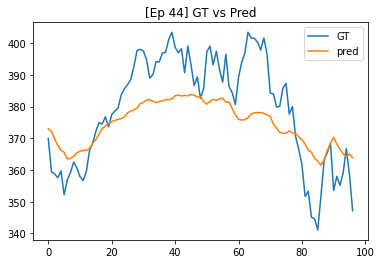

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 299.88it/s]



[EP 45] Train LOSS: 0.0281


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3494.74it/s]



[EP 45] Val LOSS: 0.0647


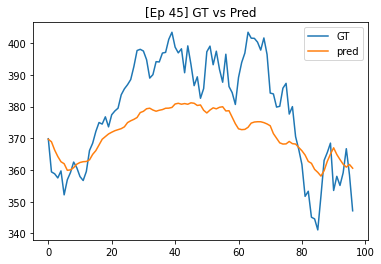

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 301.04it/s]



[EP 46] Train LOSS: 0.0615


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3739.99it/s]



[EP 46] Val LOSS: 0.0533


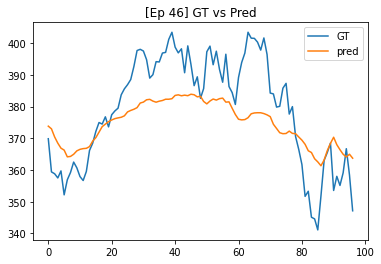

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 303.96it/s]



[EP 47] Train LOSS: 0.0366


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3582.51it/s]



[EP 47] Val LOSS: 0.0696


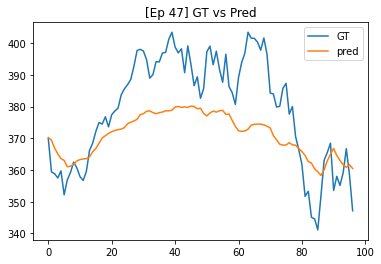

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 305.93it/s]



[EP 48] Train LOSS: 0.0457


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3367.72it/s]



[EP 48] Val LOSS: 0.0612


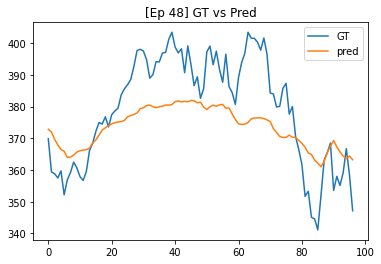

100%|████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 315.22it/s]



[EP 49] Train LOSS: 0.0473


100%|███████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 3810.36it/s]



[EP 49] Val LOSS: 0.0975


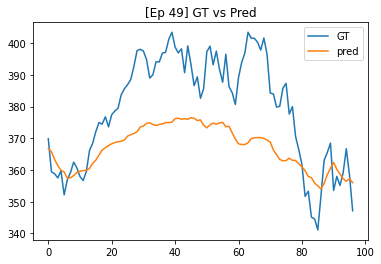

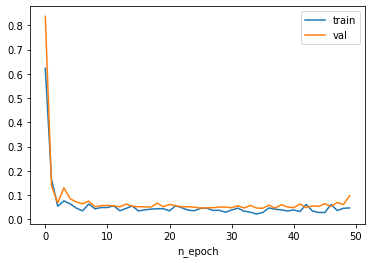

In [190]:
input_size, hidden_size, num_layers, dropout = 10, 64, 1, 0.2
net = LSTMNet(input_size, hidden_size, num_layers, dropout)
loss_fn = nn.MSELoss()
batch_size, n_epoch, lr = 32, 50, 1e-3

a = train_main(net, train_set, val_set, loss_fn, batch_size, lr, n_epoch)


In [192]:
net

LSTMNet(
  (norm1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(10, 64, batch_first=True, dropout=0.2)
  (regressor): Linear(in_features=64, out_features=1, bias=True)
)